# TP3 Reconstruction of DOSY NMR signals - Part II

## Maximum entropy regularization

### 1. Is ent convex ? proper ? lower-semicontinuous ? differentiable ?


The epigraph of $\phi$ is closed so $\phi$ is l.s.c...

### 2. Has the optimization problem a solution ? Is it unique ?


strictly convex

### 3. Give the expression of the proximity operator of ent at some x ∈ R
N .
(Hint : Use the Lambert W-function).

$$\text{prox}_{\gamma \phi}(u) = \gamma W \left( e^{\frac{u}{\gamma} -1 - \ln(\gamma)} \right)$$

### 4. Propose a forward-backward and a Douglas-Rachford algorithm to solve problem

$$f(x) = \frac{1}{2} \left\lVert Kx - y \right\rVert ^2 $$
$$g(x) = \beta \,\text{ent}(x)$$

...write algo

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import exp#, log
from math import log
from scipy import linalg
from scipy.special import lambertw
from tqdm import tqdm

T_MIN = 1
T_MAX = 1000
N = 200
M = 50
t_MIN = 0
t_MAX = 1.5

original_signal = np.loadtxt('x.txt')

def T_sampling(n):
    return T_MIN * exp(-(n-1)*(log(T_MIN/T_MAX)/(N-1)))

T = T_sampling(np.arange(1, N+1))

def t_sampling(m):
    return t_MIN + (m-1)/(M-1) * (t_MAX - t_MIN)
t = t_sampling(np.arange(1, M+1))

K = exp(-np.tensordot(t, T, axes = 0))

z = K @ original_signal
sigma = 0.01 * z[0]
I_M = np.identity(M)
cov = sigma**2 * I_M
mean = np.zeros(M)

w = np.random.multivariate_normal(mean, cov)
y = z + w

K_SQUARE = K.T @ K
KY = K.T @ y

def relative_change(x, x_new):
    return linalg.norm(x_new-x) / linalg.norm(x)

#### Douglas-Rachford algorithm

$$\text{prox}_{\gamma f} (x) = \left(\gamma K^T K + Id \right)^{-1} \left( x + \gamma K^T y \right)$$
$$\text{prox}_{\gamma g}(x) =\text{prox}_{\gamma \beta \, \text{ent}} (x) = \text{prox}_{\sum \gamma \beta \, \phi} (x) =  \left( \text{prox}_{\gamma \beta \, \phi} (x_i) \right)_i = \left( \gamma \beta \, W \left( e^{\frac{x_i}{\gamma\beta} -1 - \ln(\gamma\beta)} \right) \right)_i$$

### 5. Implement them both and evaluate their performances for β = 10−2

In [10]:
ID = np.identity(N)

def prox_f(gamma, x):
    argmin = linalg.solve(gamma*K_SQUARE + ID, x+gamma*KY)
    return argmin

def prox_g(gamma, x): # gamma = gamma*beta!
    return gamma * np.real(lambertw(exp(x/gamma -1 - log(gamma))))

def Douglas_Rachford(x_0, gamma, beta, lamb = 1/2, STOP = 1e-6, MAX_ITER = int(1e6)):
    
    x = x_0
#     breakpoint()
    for _ in tqdm(range(MAX_ITER)):
        y = prox_g(gamma*beta, x)
        z = prox_f(gamma, 2*y-x)
        x_next = x + lamb * (z - y)
        change_rate = relative_change(x, x_next)
        x = x_next
        if change_rate < STOP:
            return x
    return x
            

In [11]:
beta = 1e-2
x_0 = original_signal#np.ones(N)*(x_max+x_min)/2
restored_signal = Douglas_Rachford(x_0, 1, beta)

  0%|                                                                            | 77/1000000 [00:00<40:07, 415.33it/s]


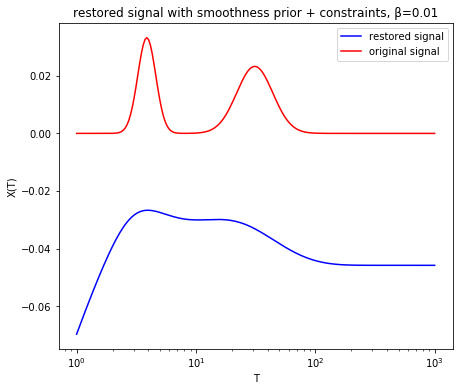

In [12]:
plt.rcParams['figure.figsize'] = [24, 6]

plt.figure()
plt.subplot(1, 3, 1)
plt.plot(T, restored_signal, 'b-', label='restored signal')
plt.plot(T, original_signal, 'r-', label='original signal')
plt.title('restored signal with smoothness prior + constraints, \u03B2={}'.format(beta))
plt.legend()
plt.xscale('log')
plt.xlabel('T')
plt.ylabel('X(T)');

### 8.

PPXA+    